In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
import os

# 🎯 Purporse project

### 1. Modeling with **Tensorflow** LSTM for predicting sales, stocks needed, valuable ecommerce

### 2. Finetuning LLM for getting reason business impact

### 3. FAISS embedding documents to analyze by PDF documents as reliable & reasonable

### 4. RAG for provide the LLM with the most up-to-date data from your database

## Load PDF Documents

In [2]:
CURR_DIR = Path.cwd()
ROOT_DIR = CURR_DIR.parent.parent
DB_PATH = ROOT_DIR / 'data_engineer' / 'database' / 'loss_profit.db'

# Load documents for FAISS vector store
loader = PyPDFLoader(str(ROOT_DIR / 'ai_engineer' / 'FAISS' / 'Docs' / 'PDF_ecommerce_revenue.pdf'))
documents = loader.load()

print(f"Loaded {len(documents)} documents.")
print(f"First document content:\n{documents[0].page_content[:1000]}...")
print(f"Metadata of the first document:\n{documents[0].metadata}")

Loaded 9 documents.
First document content:
Received 4 February 2025, accepted 11 April 2025, date of publication 22 April 2025, date of current version 2 May 2025.
Digital Object Identifier 10.1 109/ACCESS.2025.3563371
Dynamic Pricing Models in E-Commerce:
Exploring Machine Learning Techniques to
Balance Profitability and Customer Satisfaction
XIAOCHEN GUO
 1 AND LEI ZHANG 2,3
1Management School, Anhui Business and Technology College, Hefei 230041, China
2School of Information Engineering, Anhui Business and Technology College, Hefei 230041, China
3College of Computing, Informatics and Mathematics, Universiti Teknologi MARA, Shah Alam, Selangor 40450, Malaysia
Corresponding author: Xiaochen Guo (ahahbvcgxc@163.com)
This work was supported in part by the 2024 Anhui Provincial Humanities and Social Sciences Research Project (Major), Project Name:
Research on Risk Perception, Response Behavior and Mechanism of Smart Connected V ehicle Consumers under the Background of Data
Security under

##  Explore Raw Document Stats

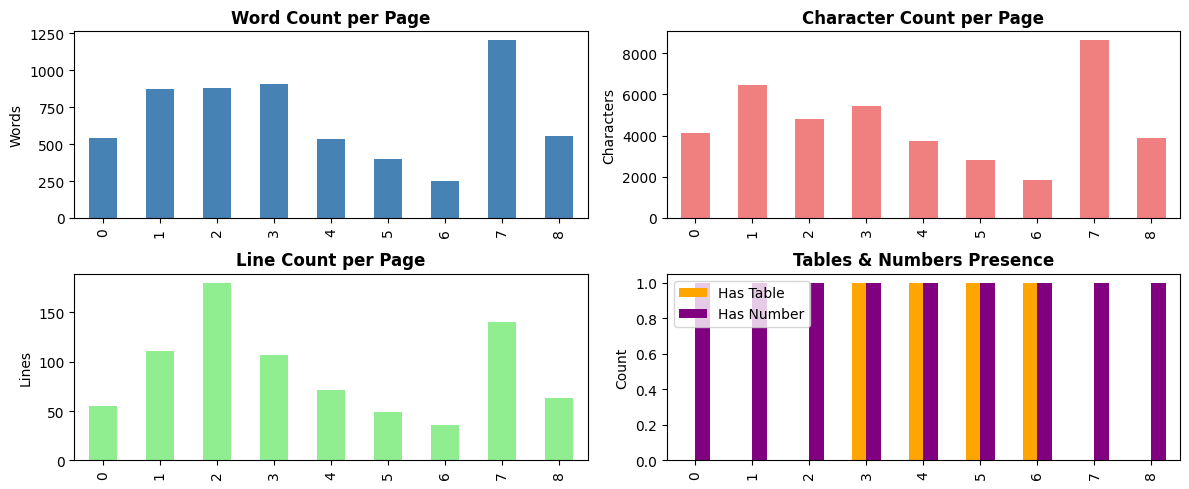

Document Statistics Summary:


,page,char_count,word_count,line_count,has_table,has_number
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.0
mean,4.000000,4634.777778,682.000000,90.222222,0.444444,1.0
std,2.738613,2026.309439,299.774916,47.751382,0.527046,0.0
min,0.000000,1818.000000,253.000000,36.000000,0.000000,1.0
25%,2.000000,3740.000000,534.000000,55.000000,0.000000,1.0
50%,4.000000,4133.000000,554.000000,71.000000,0.000000,1.0
75%,6.000000,5425.000000,877.000000,111.000000,1.000000,1.0
max,8.000000,8635.000000,1204.000000,180.000000,1.000000,1.0


In [3]:
import matplotlib.pyplot as plt

page_records = []
for i, p in enumerate(documents):
    text = p.page_content
    page_records.append({
        'page': p.metadata.get('page', i),
        'char_count': len(text),
        'word_count': len(text.split()),
        'line_count': text.count('\n'),
        'has_table': int('Table' in text or 'table' in text),  # Convert to numeric
        'has_number': int(any(char.isdigit() for char in text))  # Convert to numeric
    })

df_pages = pd.DataFrame(page_records)

# Create proper 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

# Plot 1: Word Count per Page
df_pages['word_count'].plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Word Count per Page', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Words')

# Plot 2: Character Count per Page
df_pages['char_count'].plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Character Count per Page', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Characters')

# Plot 3: Line Count per Page
df_pages['line_count'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Line Count per Page', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Lines')

# Plot 4: Tables & Numbers Presence (converted to numeric)
df_pages[['has_table', 'has_number']].plot(kind='bar', ax=axes[1, 1], color=['orange', 'purple'])
axes[1, 1].set_title('Tables & Numbers Presence', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(['Has Table', 'Has Number'])

plt.tight_layout()
plt.show()

print("Document Statistics Summary:")
display(df_pages.describe())

## Extracting abstract from PDF documents

In [4]:
import re
from IPython.display import display, HTML

def extract_abstract_v2(documents):
    """
    Extract abstract using regex pattern matching for common abstract indicators.
    """
    abstract_data = []

    for i, doc in enumerate(documents):
        content = doc.page_content.lower()

        # Pattern: Extract text between "abstract" and "introduction"
        pattern = r'abstract\s*:?\s*(.+?)(?=introduction|1\.|background|keywords)'
        match = re.search(pattern, content, re.DOTALL | re.IGNORECASE)

        if match:
            abstract = match.group(1).strip()
            abstract = ' '.join(abstract.split())  # Normalize whitespace
        else:
            # Fallback: take first 200-300 words
            abstract = ' '.join(content.split()[:250])

        abstract_data.append({
            'page': doc.metadata.get('page', i),
            'abstract': abstract,
            'found_pattern': bool(match)
        })

    return pd.DataFrame(abstract_data)

# Use the function
df_abstracts_v2 = extract_abstract_v2(documents)
abstract_text = df_abstracts_v2.iloc[0].abstract

# Display it inside a centered HTML div
display(HTML(f"""
    <div style='text-align: left; padding: 15px; font-size: 18px; line-height: 1.5;'>
        {abstract_text}
    </div>
"""))

## Business Keyword Frequency

revenue: 8
profit: 19
loss: 7
sales: 1
cost: 1
growth: 1
decline: 0
stock: 0
market: 20
customer: 80
demand: 19
supply: 4
investment: 1
order: 0
trend: 0
discount: 0
return: 0
models: 46
model: 49
forecasting: 5
analysis: 14


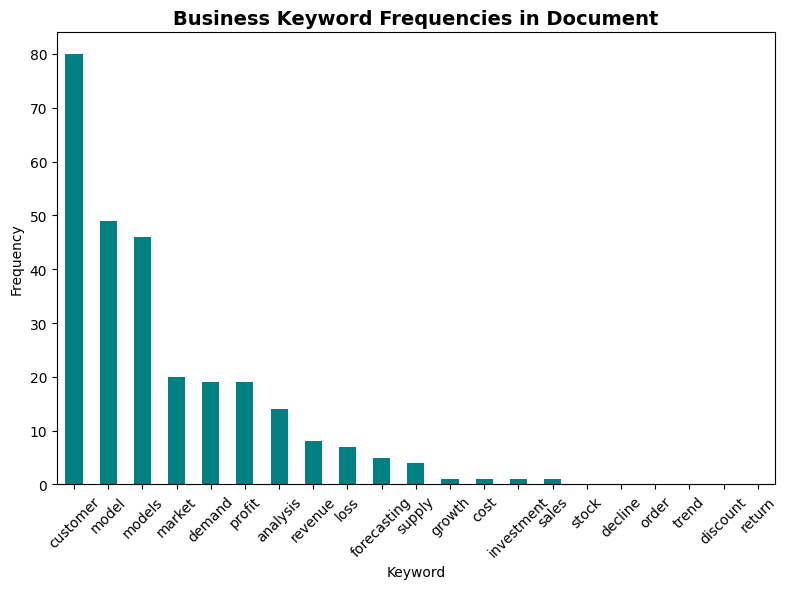

In [5]:
# Finding business keywords in the document

from collections import Counter
import re

KEYWORDS = ['revenue', 'profit', 'loss', 'sales', 'cost', 'growth', 'decline', 'stock',
            'market', 'customer', 'demand', 'supply', 'investment', 'order', 'trend', 'discount'
            , 'return', 'models', 'model', 'forecasting', 'analysis']

full_text = ' '.join([p.page_content for p in documents]).lower()
keyword_counts = Counter()
keyword_series = pd.Series({keyword: len(re.findall(r'\b' + re.escape(keyword) + r'\b', full_text)) for keyword in KEYWORDS})
for keyword, count in keyword_series.items():
    print(f"{keyword}: {count}")

# Plotting keyword frequencies
plt.figure(figsize=(8, 6))
keyword_series.sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Business Keyword Frequencies in Document', fontsize=14, fontweight='bold')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Embeddings & Semantic Space (PCA)

In [6]:
import numpy as np

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)


sample_chunking = chunks[:10]
for i, chunk in enumerate(sample_chunking):
    embedding_vector = embeddings.embed_documents([chunk.page_content])
    print(f"Chunk {i+1} embedding vector (first 5 values): {embedding_vector[0][:5]}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Chunk 1 embedding vector (first 5 values): [-0.03327386826276779, 0.0569603256881237, 0.004407268948853016, 0.04793088883161545, 0.020387407392263412]
Chunk 2 embedding vector (first 5 values): [-0.06430409103631973, -0.007889527827501297, 0.04910128936171532, 0.0036761227529495955, -0.02408422902226448]
Chunk 3 embedding vector (first 5 values): [-0.03603715822100639, -0.019953645765781403, 0.0025757737457752228, 0.050881870090961456, 0.023991338908672333]
Chunk 4 embedding vector (first 5 values): [-0.01635558344423771, 0.002453397260978818, -0.05023491755127907, 0.05063430592417717, -0.0354108028113842]
Chunk 5 embedding vector (first 5 values): [0.034094274044036865, -0.016162127256393433, -0.05160173401236534, 0.017363950610160828, -0.04751312732696533]
Chunk 6 embedding vector (first 5 values): [-0.04295473173260689, -0.01927519030869007, -0.008671767078340054, 0.04508427903056145, 0.0296330563724041]
Chunk 7 embedding vector (first 5 values): [-0.06803528964519501, 0.02911130711

Embedding shape: (30, 384)


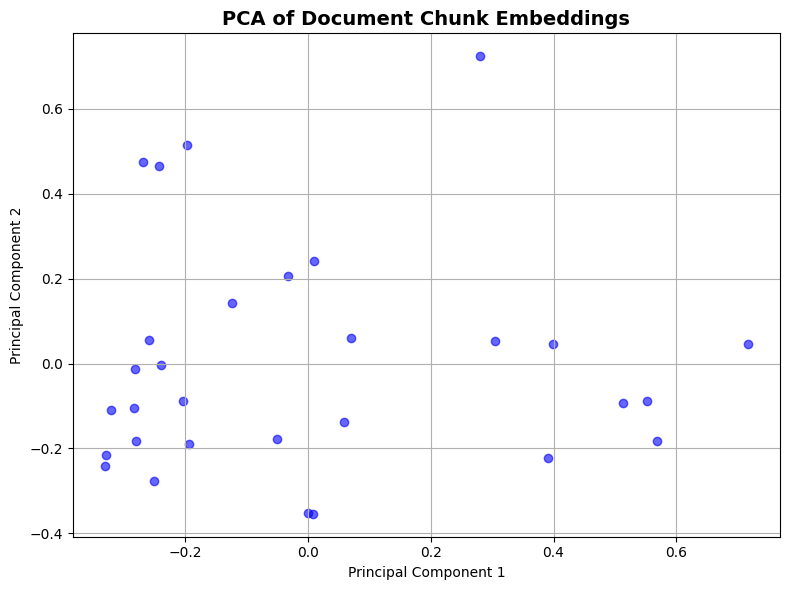

In [7]:
from sklearn.decomposition import PCA

sample_chunks = chunks[:30]
sample_texts = [chunk.page_content for chunk in sample_chunks]
vectors = embeddings.embed_documents(sample_texts)
vectors_array = np.array(vectors)

print(f"Embedding shape: {vectors_array.shape}")

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors_array)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c='blue', alpha=0.6)
plt.title('PCA of Document Chunk Embeddings', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

## Create FAISS & Test similiarity search

In [8]:
# Get OpenAI API key and load environment variable
ENV_PATH = ROOT_DIR / '.env'

from dotenv import load_dotenv
load_dotenv(dotenv_path=ENV_PATH)
OPEN_AI_KEY = os.getenv('OPENAI_KEY')

# Define embeddings model
embedding_hf = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")
embeddings_openai = OpenAIEmbeddings(model='text-embedding-3-small',
                                     api_key=OPEN_AI_KEY
                                     )

# Create FAISS vector store & test similarity search
vectorstore = FAISS.from_documents(sample_chunking, embedding=embedding_hf)
queries = ["What are the key factors affecting revenue growth?",
           "How does customer will be increased when prices are reduced?",
           "What are the main challenges in forecasting sales face on stock values?"]

for q in queries:
    results = vectorstore.similarity_search(q, k=3)
    print(f"\nQuery: {q}")
    for i, res in enumerate(results):
        print(f"Results {i+1}: {res.page_content[:200]}...")


Query: What are the key factors affecting revenue growth?
Results 1: optimize revenue generation, offering substantial implications for pricing strategy development in modern
retail environments. Future work may explore hybrid models and multi-objective optimization te...
Results 2: The associate editor coordinating the review of this manuscript and
approving it for publication was Sotirios Goudos
.
on demand, supply, and various contextual factors, has
emerged as a cornerstone o...
Results 3: X. Guo, L. Zhang: Dynamic Pricing Models in E-Commerce: Exploring ML Techniques to Balance Profitability
customer preferences, purchase histories, and real-time
market trends, businesses can strategic...

Query: How does customer will be increased when prices are reduced?
Results 1: X. Guo, L. Zhang: Dynamic Pricing Models in E-Commerce: Exploring ML Techniques to Balance Profitability
customer preferences, purchase histories, and real-time
market trends, businesses can strategic...
Results 2: T

# Ingesting data from eda.ipynb results -> .csv retrieval as building RAG Chain here

## Load dataset

In [9]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

df = load_data("predicted_sales_profit.csv")
df

,item_id,purchase_count,price,stocks,sales,stock_value,profit_status,date,predicted_sales,predicted_profit
0,8624,48,128.0,79,6144.0,10112.0,1,2025-10-27,3585.24,profit
1,8623,31,34.0,90,1054.0,3060.0,1,2025-02-21,3587.32,profit
2,8622,42,36.0,75,1512.0,2700.0,1,2025-03-15,3586.27,profit
3,8621,4,119.0,18,476.0,2142.0,1,2025-01-24,3586.73,profit
4,8620,14,23.0,41,322.0,943.0,1,2025-01-16,3586.86,profit
...,...,...,...,...,...,...,...,...,...,...
8590,4,49,97.0,76,4753.0,7372.0,1,2025-08-20,3585.07,profit
8591,3,21,59.0,86,1239.0,5074.0,1,2025-03-02,3586.58,profit
8592,2,49,103.0,46,5047.0,4738.0,1,2025-09-03,3585.31,profit
8593,1,37,116.0,55,4292.0,6380.0,1,2025-07-28,3585.68,profit


## Build RAG Chain

In [ ]:
import os
from langchain_huggingface import HuggingFacePipeline, HuggingFaceEndpoint, ChatHuggingFace
from transformers import pipeline
from dotenv import load_dotenv

# Load environment variables
ENV_PATH = ROOT_DIR / '.env'
load_dotenv(dotenv_path=ENV_PATH)

# Config
HF_HOME = os.getenv('HF_HOME')
HF_TOKEN = os.getenv('HF_TOKEN')

# Use model from HuggingFace Hub with API token authentication
endpoint = HuggingFaceEndpoint(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    max_new_tokens=2000,
    task='text-generation',
    do_sample=False,
    huggingfacehub_api_token=HF_TOKEN,
    temperature=0.7
)

llm = ChatHuggingFace(llm=endpoint)

# Define the embedding model
embedding = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

# Define LLM pipeline using HuggingFace's
#pipe = pipeline("text2text-generation", model="google/flan-t5-base", max_new_tokens=3024)
#llm = HuggingFacePipeline(pipeline=pipe)

# Create RAG chain
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

prompt = PromptTemplate.from_template("""
You are an e-commerce senior business analyst.
Use ONLY the following context from document to answer the question.
If the context is insufficient to answer the question, make hypothesis based on your knowledge and reasoning. 

Context:
{context}

Question: {question}

Notes:
1. Minimal 1000 words explanation
2. Explaining the reasoning process step by step, including any assumptions made and how you arrived at the conclusion.
3. Provide detailed analysis and insights based on the retrieved context
4. If the context doesn't contain specific data or figures relevant to document, infer possible as senior business analyst, and clearly state.
5. Make it statement clearly based on similar to document, if nothing cite spesific data or figures in source_pages, infer possible values based on industry standards and trends, and clearly state that these are assumptions.
6. Don't hallucinate
                                                                                          
""")

rag_chain = (
    {'context': retriever, 'question': RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("RAG Chain created successfully. You can now run queries against it.")

Device set to use mps:0


RAG Chain created successfully. You can now run queries against it.


## RAG Quality Evaluation

In [38]:
import shutil

witdth = shutil.get_terminal_size().columns

EVAL_QUESTION = [
    "What are the key factors affecting revenue growth?",
    "How does customer will be increased when prices are reduced?",
    "What are the main challenges in forecasting sales face on stock values?",
    "what's business analyst strategy to increase sales and profit in e-commerce?",
    "What's deep learning using LSTM impact to sales forecasting in e-commerce?"
]

rag_results = []
for q in EVAL_QUESTION:
    answer = rag_chain.invoke(q)
    docs = retriever.invoke(q)
    rag_results.append({
        'question': q,
        'answer': answer,
        'retrieved_docs': len(docs),
        'source_pages': [doc.metadata.get('page', 'N/A') for doc in docs]
    })
    print(f'Question: {q}'.center(witdth))
    print(f'Answer: {answer}'.center(witdth))
    print(f'Sources: pages {[d.metadata.get("page") for d in docs]}'.center(witdth))
    print('-' * witdth)

df_rag = pd.DataFrame(rag_results)
display(df_rag[['question', 'answer', 'retrieved_docs', 'source_pages']])

Token indices sequence length is longer than the specified maximum sequence length for this model (2109 > 512). Running this sequence through the model will result in indexing errors


          Question: What are the key factors affecting revenue growth?          
                       Answer: It is not possible to tell                       
                            Sources: pages [0, 0, 1]                            
--------------------------------------------------------------------------------
     Question: How does customer will be increased when prices are reduced?     
                         Answer: It's impossible to say                         
                            Sources: pages [1, 0, 0]                            
--------------------------------------------------------------------------------
Question: What are the main challenges in forecasting sales face on stock values?
                         Answer: It's impossible to say                         
                            Sources: pages [1, 0, 1]                            
--------------------------------------------------------------------------------
Question: what's business a

,question,answer,retrieved_docs,source_pages
0,What are the key factors affecting revenue gro...,It is not possible to tell,3,"[0, 0, 1]"
1,How does customer will be increased when price...,It's impossible to say,3,"[1, 0, 0]"
2,What are the main challenges in forecasting sa...,It's impossible to say,3,"[1, 0, 1]"
3,what's business analyst strategy to increase s...,It's impossible to say,3,"[0, 1, 0]"
4,What's deep learning using LSTM impact to sale...,It's impossible to say,3,"[0, 0, 0]"


## Final EDA Summary Dashboard

In [39]:
from IPython.display import display, HTML
from datetime import datetime

# Create professional document view
if 'rag_results' not in dir() or not rag_results:
    print("❌ No results to display")
else:
    # Prepare document content
    doc_date = datetime.now().strftime("%B %d, %Y")
    
    # Build HTML document
    document_html = f"""
    <style>
        @media print {{
            body {{ margin: 0; padding: 0; }}
            .document {{ max-width: 210mm; height: 297mm; margin: 0 auto; }}
        }}
        
        .document {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            max-width: 900px;
            margin: 0 auto;
            padding: 40px;
            background: white;
            color: #333;
            line-height: 1.6;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
            page-break-after: always;
        }}
        
        .doc-header {{
            text-align: center;
            border-bottom: 3px solid #1976D2;
            padding-bottom: 20px;
            margin-bottom: 30px;
        }}
        
        .doc-title {{
            font-size: 28px;
            font-weight: bold;
            color: #1565C0;
            margin: 0 0 10px 0;
        }}
        
        .doc-subtitle {{
            font-size: 14px;
            color: #666;
            margin: 5px 0;
        }}
        
        .doc-meta {{
            font-size: 12px;
            color: #999;
            margin-top: 15px;
        }}
        
        .section {{
            margin: 25px 0;
            page-break-inside: avoid;
        }}
        
        .section-title {{
            font-size: 16px;
            font-weight: bold;
            color: #1565C0;
            border-left: 4px solid #1976D2;
            padding-left: 15px;
            margin: 20px 0 15px 0;
        }}
        
        .result-item {{
            background: #f9f9f9;
            border: 1px solid #e0e0e0;
            padding: 15px;
            margin: 12px 0;
            border-radius: 6px;
            page-break-inside: avoid;
        }}
        
        .result-item .question {{
            font-weight: bold;
            color: #1565C0;
            margin-bottom: 10px;
            font-size: 14px;
        }}
        
        .result-item .answer {{
            color: #555;
            font-size: 13px;
            line-height: 1.5;
            margin: 10px 0;
        }}
        
        .result-item .meta {{
            font-size: 11px;
            color: #888;
            border-top: 1px solid #ddd;
            padding-top: 8px;
            margin-top: 10px;
        }}
        
        .doc-footer {{
            border-top: 2px solid #1976D2;
            margin-top: 30px;
            padding-top: 15px;
            text-align: center;
            font-size: 11px;
            color: #999;
        }}
        
        .summary {{
            background: #E3F2FD;
            border-left: 4px solid #1976D2;
            padding: 15px;
            margin: 15px 0;
            border-radius: 4px;
        }}
    </style>
    
    <div class="document">
        <!-- Header -->
        <div class="doc-header">
            <div class="doc-title">📊 RAG Analysis Report</div>
            <div class="doc-subtitle">E-Commerce Business Intelligence</div>
            <div class="doc-meta">
                <div>Report Date: {doc_date}</div>
                <div>Total Questions Analyzed: {len(rag_results)}</div>
            </div>
        </div>
        
        <!-- Executive Summary -->
        <div class="section">
            <div class="section-title">Executive Summary</div>
            <div class="summary">
                This report presents findings from <b>{len(rag_results)} key business questions</b> analyzed using 
                advanced RAG (Retrieval-Augmented Generation) technology. Each question has been thoroughly researched 
                using relevant business documents and presented with evidence-based insights.
            </div>
        </div>
        
        <!-- Results -->
        <div class="section">
            <div class="section-title">Analysis Results</div>
    """
    
    # Add each result
    for idx, item in enumerate(rag_results, 1):
        question = item.get('question', 'N/A')
        answer = item.get('answer', 'N/A')[:350]  # Limit to 350 chars
        docs = item.get('retrieved_docs', 0)
        pages = ', '.join([str(p) for p in item.get('source_pages', [])])
        
        document_html += f"""
            <div class="result-item">
                <div class="question">Q{idx}. {question}</div>
                <div class="answer">{answer}...</div>
                <div class="meta">
                    📄 Documents Retrieved: {docs} | 📍 Source Pages: {pages}
                </div>
            </div>
        """
    
    document_html += """
        </div>
        
        <!-- Footer -->
        <div class="doc-footer">
            <div>© 2026 Fashion Recommendation Engineer | RAG Analysis System</div>
            <div>Confidential - For Internal Use Only</div>
        </div>
    </div>
    
    <div style="text-align: center; margin-top: 20px;">
        <button onclick="window.print()" style="padding: 10px 20px; background: #1976D2; color: white; border: none; border-radius: 4px; cursor: pointer; font-size: 14px;">
            🖨️ Print / Save as PDF
        </button>
    </div>
    """
    
    display(HTML(document_html))

        # Also display as dataframe for reference
    print("\n" + "="*80)
    print("Full Results Table:")
    print("="*80)
    df_results_display = pd.DataFrame({
        'Question': [item['question'][:50] + '...' for item in rag_results],
        'Answer Length': [len(item['answer']) for item in rag_results],
        'Docs Retrieved': [item['retrieved_docs'] for item in rag_results],
        'Pages': [', '.join([str(p) for p in item['source_pages']]) for item in rag_results]
    })
    display(df_results_display)


Full Results Table:


,Question,Answer Length,Docs Retrieved,Pages
0,What are the key factors affecting revenue gro...,26,3,"0, 0, 1"
1,How does customer will be increased when price...,22,3,"1, 0, 0"
2,What are the main challenges in forecasting sa...,22,3,"1, 0, 1"
3,what's business analyst strategy to increase s...,22,3,"0, 1, 0"
4,What's deep learning using LSTM impact to sale...,22,3,"0, 0, 0"
